In [2]:
!cp *.jar $SPARK_HOME/jars/

In [1]:
!ls $SPARK_HOME/jars | grep bigdl

bigdl-assembly-spark_3.1.3-2.4.0-jar-with-dependencies.jar


In [3]:
!export ZOO_STANDALONE_HOME=/opt/work/bigdl-2.4.0

In [4]:
!pip install pillow opencv-python 

# Imports and Environment Setup

In [1]:
# pneumonia_detection_fixed.py
# Simplified version with proper data format for BigDL
import hdfs
import os
import sys
import math
import psutil
import time
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from hdfs import InsecureClient
from pyspark import SparkConf, SparkContext
from bigdl.orca import init_orca_context, stop_orca_context, OrcaContext
from bigdl.orca.learn.tf2 import Estimator
from bigdl.orca.data import SparkXShards
from pyspark.sql import SparkSession
from tensorflow.keras import regularizers 
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix,precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from collections import defaultdict, Counter
from random import shuffle

# Ensure Spark uses the same Python interpreter
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

2025-05-27 21:52:35.065180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-27 21:52:35.065234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/work/bigdl-2.4.0/python/bigdl-spark_3.1.3-2.4.0-python-api.zip/bigdl/dllib/utils/engine.py:47: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /opt/spark, and pyspark is found in: /opt/work/spark-3.1.3/python/lib/pyspark.zip/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
/opt/work/bigdl-2.4.0/python/bigdl-spark_3.1.3-2.4.0-python-api.zip/bigdl/dllib/utils/zoo_engine.py:47: UserWarning: Find both SPARK

# System Stats and HDFS Connection

In [2]:
def log_system_stats(prefix=""):
    """Log current system resource usage"""
    mem = psutil.virtual_memory()
    stats = (f"{prefix} System Stats - "
             f"Memory: {mem.percent}% used ({mem.used/1e9:.1f}GB/{mem.total/1e9:.1f}GB) | "
             f"CPU: {psutil.cpu_percent()}% | "
             f"Disk: {psutil.disk_usage('/').percent}%")
    print(stats)

def setup_hdfs_client(hdfs_url="http://namenode:9870"):
    """Initialize HDFS client"""
    try:
        client = InsecureClient(hdfs_url, user=os.getenv('USER', 'root'))
        # Test connection
        client.status('/')
        return client
    except Exception as e:
        print(f"Failed to connect to HDFS: {e}")
        return None

def copy_from_hdfs(hdfs_client, hdfs_path, local_path):
    """Copy files from HDFS to local using Python client"""
    if not os.path.exists(local_path):
        os.makedirs(local_path)
    
    try:
        print(f"Copying {hdfs_path} to {local_path}")
        hdfs_client.download(hdfs_path, local_path, overwrite=True)
        return True
    except Exception as e:
        print(f"Error copying from HDFS: {e}")
        return False

# Image Loading and Preprocessing

In [3]:
def load_images_locally(hdfs_path, local_cache='/tmp/xray_cache', sample_fraction=1.0, balance_classes=False):
    """Copy files from HDFS to local cache and load them"""
    hdfs_client = setup_hdfs_client()
    if not hdfs_client:
        return None, None

    # Define local folders
    normal_local = os.path.join(local_cache, 'NORMAL')
    pneumonia_local = os.path.join(local_cache, 'PNEUMONIA')
    
    print(f"Copying files from HDFS to local cache: {local_cache}")
    
    # Copy data from HDFS
    normal_hdfs = os.path.join(hdfs_path, 'NORMAL')
    pneumonia_hdfs = os.path.join(hdfs_path, 'PNEUMONIA')
    
    if not (copy_from_hdfs(hdfs_client, normal_hdfs, normal_local) and 
            copy_from_hdfs(hdfs_client, pneumonia_hdfs, pneumonia_local)):
        return None, None

    # Collect image paths and labels
    image_paths = []
    labels = []
    for root, _, files in os.walk(local_cache):
        for file in files:
            if file.lower().endswith(('.jpeg', '.jpg', '.png')):
                full_path = os.path.join(root, file)
                label = 1 if os.path.basename(root).upper() == 'PNEUMONIA' else 0
                image_paths.append(full_path)
                labels.append(label)

    # Sample if requested
    if sample_fraction < 1.0:
        sample_size = max(1, int(len(image_paths) * sample_fraction))
        indices = np.random.choice(len(image_paths), size=sample_size, replace=False)
        image_paths = [image_paths[i] for i in indices]
        labels = [labels[i] for i in indices]

    # Balance classes if requested
    if balance_classes:
        image_paths, labels = balance_image_classes(image_paths, labels)

    print("Loaded label counts:", dict(Counter(labels)))
    return image_paths, labels


def preprocess_image_batch(image_paths, labels):
    """Preprocess a batch of images into numpy arrays"""
    images = []
    valid_labels = []
    
    for i, (path, label) in enumerate(zip(image_paths, labels)):
        try:
            img = load_img(path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            valid_labels.append(label)
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    
    if not images:
        return None, None
        
    # Convert to numpy arrays
    x_data = np.array(images, dtype=np.float32)
    y_data = np.array(valid_labels, dtype=np.float32).reshape(-1, 1)
    
    return x_data, y_data

# Balancing classes

In [4]:
def balance_image_classes(image_paths, labels):
    """Balance image paths and labels to have equal class representation"""
    class_indices = defaultdict(list)
    for i, label in enumerate(labels):
        class_indices[label].append(i)

    min_class_size = min(len(idxs) for idxs in class_indices.values())
    
    balanced_indices = []
    for idxs in class_indices.values():
        shuffle(idxs)
        balanced_indices.extend(idxs[:min_class_size])
    
    shuffle(balanced_indices)
    
    return [image_paths[i] for i in balanced_indices], [labels[i] for i in balanced_indices]


# SparkXShards Creation

In [5]:
def create_simple_shards(x_data, y_data, spark, batch_size=8):
    """Create SparkXShards from preprocessed numpy arrays"""
    # Split data into batches
    num_samples = len(x_data)
    num_batches = math.ceil(num_samples / batch_size)
    
    batch_data = []
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        
        batch_x = x_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        # Create the format expected by BigDL
        batch_data.append({
            'x': batch_x,
            'y': batch_y
        })
    
    # Create RDD from batch data
    rdd = spark.sparkContext.parallelize(batch_data, numSlices=min(len(batch_data), 4))
    return SparkXShards(rdd)

# Model Architecture

In [6]:
def create_simple_model(config):
    l2_reg = regularizers.l2(config.get('l2', 1e-4))
    
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same',
                                        kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(config.get('dropout', 0.3))(x)

    x = tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same',
                                        kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(config.get('dropout', 0.3))(x)

    x = tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same',
                                        kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(config.get('dropout', 0.3))(x)

    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(config.get('dropout', 0.3))(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(config.get('lr', 1e-4)),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Training and Evaluation

In [7]:
def run_training_phase(train_paths, train_labels, val_paths, val_labels, spark):
    print(f"\n{'='*50}")
    log_system_stats("Before training:")
    
    try:
        # Preprocess training images
        print("Preprocessing training images...")
        x_train, y_train = preprocess_image_batch(train_paths, train_labels)
        
        if x_train is None or len(x_train) == 0:
            print("No valid training images processed")
            return False,None

        y_train_flat = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train
        y_train_flat = np.array(y_train_flat).flatten().astype(int)  # ensure 1D int array
        
        unique, counts = np.unique(y_train_flat, return_counts=True)
        print("Class distribution in training data:", dict(zip(unique, counts)))

        
        # Preprocess validation images
        print("Preprocessing validation images...")
        x_val, y_val = preprocess_image_batch(val_paths, val_labels)
        
        if x_val is None or len(x_val) == 0:
            print("No valid validation images processed")
            return False,None
        
        print(f"Training data shapes - X: {x_train.shape}, Y: {y_train.shape}")
        print(f"Validation data shapes - X: {x_val.shape}, Y: {y_val.shape}")
        
        # Create shards for training data
        batch_size = 8
        train_shards = create_simple_shards(x_train, y_train, spark, batch_size)
        
        # Calculate steps
        steps = max(1, math.ceil(len(x_train) / batch_size))
        
        unique_classes = np.unique(y_train_flat)
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=y_train_flat
        )
        class_weight_dict = dict(zip(unique_classes, class_weights))
        
        est = Estimator.from_keras(
        model_creator=create_simple_model,
        config={
            "lr": 1e-4,
            "dropout": 0.3,
            "l2": 1e-4,
            "class_weights": class_weight_dict  
        },
        backend='spark',
        workers_per_node=1
        )
        
        print("Class weights:", class_weight_dict)
        # Train
        print("Starting model training...")
        start_time = time.time()
        est.fit(
            data=train_shards,
            feature_cols=["x"],
            label_cols=["y"],
            epochs=10,
            batch_size=batch_size,
            steps_per_epoch=steps
        )
        
        duration = time.time() - start_time
        print(f"Training completed in {duration:.2f} seconds")
        print(f"Training set size: {len(x_train)} images")
        print(f"Validation set size: {len(x_val)} images")         
        log_system_stats("After training:")
        return True,est
        
    except Exception as e:
        print(f"Training failed: {str(e)}")
        import traceback
        traceback.print_exc()
        log_system_stats("At failure:")
        return False,None

# Visualization Function

In [8]:
def visualize_results(y_true, y_pred_prob, title="Test"):
    y_pred_class = (y_pred_prob >= 0.5).astype(int)
    
    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{title} ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


# Main pipeline

Initializing Orca context...
Initializing orca context
Current pyspark location is : /opt/work/spark-3.1.3/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /opt/work/bigdl-2.4.0/jars/* pyspark-shell 


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/work/bigdl-2.4.0/jars/log4j-slf4j-impl-2.17.1.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/spark/jars/bigdl-assembly-spark_3.1.3-2.4.0-jar-with-dependencies.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


25-05-27 21:52:42 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2025-05-27 21:52:45,297 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2025-05-27 21:52:45,300 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2025-05-27 21:52:45,301 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2025-05-27 21:52:45,302 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
25-05-27 21:52:45 INFO  Engine$:122 - Auto detect executor number and executor cores number
25-05-27 21:52:45 INFO  Engine$:124 - Executor number is 1 and executor cores number is 4
25-05-27 21:52:45 INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 25
25-05-27 21:52:45 WARN  SparkContext:69 - Using an existing SparkContext; some configuration may not take effect.
2025-05-27 21:52:45 WARN  SparkContext:69 - Using an existing SparkContext; some conf


User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_INIT_WAIT=2048
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_

cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
BigDLBasePickler registering: bigdl.dllib.utils.common  Sample
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.dllib.utils.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JTensor
BigDLBasePickler registering: bigdl.dllib.utils.common  JTensor
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.JActivity
BigDLBasePickler registering: bigdl.dllib.utils.common  JActivity
Successfully got a SparkContext
25-05-27 21:52:46 INFO  Engine$:162 - Initializing JavaGatewayServer on executor-driver 
25-05-27 21:52:46 INFO  Engine$:182 - JavaGatewayServer initialized
25-05-27 21:52:46 INFO  GatewayServer:573 - Gateway Server Started


LOADING DATASETS FROM HDFS
Loading training images from HDFS: /data/chest_xray/train
Copying files from HDFS to local cache: /tmp/xray_train_cache
Copying /data/chest_xray/train/NORMAL to /tmp/xray_train_cache/NORMAL
Copying /data/chest_xray/train/PNEUMONIA to /tmp/xray_train_cache/PNEUMONIA
Loaded label counts: {1: 232, 0: 232}
Loading validation images from HDFS: /data/chest_xray/val
Copying files from HDFS to local cache: /tmp/xray_val_cache
Copying /data/chest_xray/val/NORMAL to /tmp/xray_val_cache/NORMAL
Copying /data/chest_xray/val/PNEUMONIA to /tmp/xray_val_cache/PNEUMONIA
Loaded label counts: {1: 8, 0: 8}
Loading test images from HDFS: /data/chest_xray/test
Copying files from HDFS to local cache: /tmp/xray_test_cache
Copying /data/chest_xray/test/NORMAL to /tmp/xray_test_cache/NORMAL
Copying /data/chest_xray/test/PNEUMONIA to /tmp/xray_test_cache/PNEUMONIA
Loaded label counts: {0: 23, 1: 23}

DATASET SUMMARY
Training images available: 464
Validation images: 16
Test images: 46
A

25-05-27 21:53:51 INFO  GatewayServer:519 - Connection Started
Class weights: {0: 1.0}
Starting model training...


25-05-27 21:53:52 WARN  TaskSetManager:69 - Stage 4 contains a task of very large size (65861 KiB). The maximum recommended task size is 1000 KiB.
2025-05-27 21:53:52 WARN  TaskSetManager:69 - Stage 4 contains a task of very large size (65861 KiB). The maximum recommended task size is 1000 KiB.
25-05-27 21:53:52 WARN  TaskSetManager:69 - Stage 5 contains a task of very large size (65861 KiB). The maximum recommended task size is 1000 KiB.
2025-05-27 21:53:52 WARN  TaskSetManager:69 - Stage 5 contains a task of very large size (65861 KiB). The maximum recommended task size is 1000 KiB.
25-05-27 21:53:53 WARN  TaskSetManager:69 - Stage 6 contains a task of very large size (65861 KiB). The maximum recommended task size is 1000 KiB.
2025-05-27 21:53:53 WARN  TaskSetManager:69 - Stage 6 contains a task of very large size (65861 KiB). The maximum recommended task size is 1000 KiB.


2025-05-27 21:53:54.811194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-27 21:53:54.811663: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Instructions for updating:
use distribute.MultiWorkerMirroredStrategy instead
2025-05-27 21:54:00.157139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-05-27 21:54:00.157196: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-27 21:54:00.157224: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (23c9124071a8): /proc/driver/nvidia/version d

Training completed in 296.99 seconds
Training set size: 464 images
Validation set size: 16 images
After training: System Stats - Memory: 84.1% used (6.4GB/7.9GB) | CPU: 21.9% | Disk: 7.3%

 Roc Visualization for test images...


2025-05-27 21:58:54.829807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-05-27 21:58:54.831054: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-27 21:58:54.831570: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (23c9124071a8): /proc/driver/nvidia/version does not exist
2025-05-27 21:58:54.837279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 21:58:56.059687: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exce

1/2 [==============>...............] - ETA: 0s

2025-05-27 21:58:56.272943: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
2025-05-27 21:58:56.307200: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
2025-05-27 21:58:56.403623: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 179830784 exceeds 10% of free system memory.


2/2 [==============================] - 1s 151ms/step


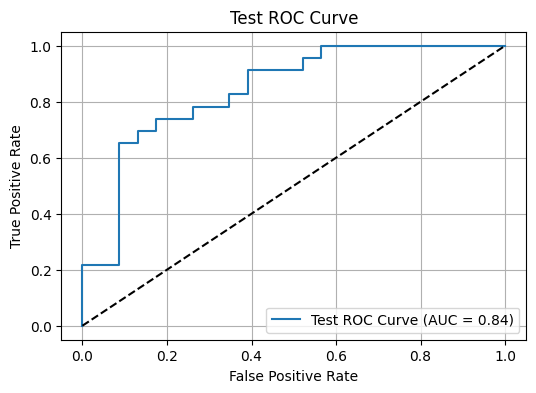


Stopping Orca context...
Stopping orca context
Done.


In [9]:
if __name__ == "__main__":
    # Configure Spark with increased timeouts and memory
    conf = {
        "spark.executor.heartbeatInterval": "60s",
        "spark.network.timeout": "600s",
        "spark.driver.memory": "4g",
        "spark.executor.memory": "4g",
        "spark.driver.maxResultSize": "2g",
        "spark.sql.adaptive.enabled": "false",
        "spark.sql.adaptive.coalescePartitions.enabled": "false"
    }
    
    # Initialize Orca context
    print("Initializing Orca context...")
    init_orca_context(
        cluster_mode="local",
        cores=4,
        memory="6g",
        conf=conf
    )
    spark = OrcaContext.get_spark_session()
    
    # Load datasets from HDFS
    print("="*60)
    print("LOADING DATASETS FROM HDFS")
    print("="*60)
    
    # Load training data
    train_hdfs_path = "/data/chest_xray/train"
    print(f"Loading training images from HDFS: {train_hdfs_path}")
    train_paths, train_labels = load_images_locally(train_hdfs_path, 
                                                   local_cache='/tmp/xray_train_cache', 
                                                   sample_fraction=0.1,balance_classes=True)
     # Load validation data  
    val_hdfs_path = "/data/chest_xray/val"
    print(f"Loading validation images from HDFS: {val_hdfs_path}")
    val_paths, val_labels = load_images_locally(val_hdfs_path, 
                                               local_cache='/tmp/xray_val_cache', 
                                               sample_fraction=1.0)
    
    # Load test data
    test_hdfs_path = "/data/chest_xray/test"
    print(f"Loading test images from HDFS: {test_hdfs_path}")
    test_paths, test_labels = load_images_locally(test_hdfs_path, 
                                                 local_cache='/tmp/xray_test_cache', 
                                                 sample_fraction=0.1,balance_classes=True)   
    # Check if data loaded successfully
    if not train_paths or not train_labels:
        print("No training images loaded. Exiting.")
        stop_orca_context()
        sys.exit(1)
    
    if not val_paths or not val_labels:
        print("No validation images loaded. Exiting.")
        stop_orca_context()
        sys.exit(1)

    if not test_paths or not test_labels:
        print("No test images loaded. Exiting.")
        stop_orca_context()
        sys.exit(1)
    
    # Print dataset info
    print("\n" + "="*60)
    print("DATASET SUMMARY")
    print("="*60)
    print(f"Training images available: {len(train_paths)}")
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths) if test_paths else 'Not loaded'}")
    
    # Count labels for validation set
    val_normal = sum(1 for label in val_labels if label == 0)
    val_pneumonia = sum(1 for label in val_labels if label == 1)
    log_system_stats("After loading all data:")
    
    print("\n" + "="*60)
    print("="*60)
    success,est = run_training_phase(train_paths, train_labels, val_paths, val_labels, spark)
    if not success:
        print(f"\nTraining failed. Exiting.")
        
    
    # --- Evaluate on test set ---
    print("\n Roc Visualization for test images...")
    x_test, y_test = preprocess_image_batch(test_paths, test_labels)
    if x_test is not None and len(x_test) > 0:
        keras_model = est.get_model()  # Get the underlying Keras model from the Estimator
        y_pred_prob = keras_model.predict(x_test).flatten()
        visualize_results(y_test.flatten(), y_pred_prob)
    else:
        print("Test data preprocessing failed or returned empty set.")
    
    # Cleanup
    print("\nStopping Orca context...")
    stop_orca_context()
    print("Done.")